In [386]:
def get_user_profile_from():
    skills = [
        'Agentic AI', 
        'Retrieval Augmented Generation (RAG)', 
        'Large Language Models (LLMs)', 
        'LangChain', 
        'Django',
        'LSTM',
        'Flask',
        'Transformers',
        'RNN',
        'TensorFlow',
        'Supervised Learning',
        'Unsupervised Learning',
        'Pytorch',
        'CNN',
        'DBMS',
        'DSA',
        'Statistics',
        'SQL',
        'AI',
        'Linear Algebra',
        'Calculus',
        'PCA',
        'Python',
        'Seaborn',
        'Pandas',
        'Numpy',
        'Matplotlib',
        'Scikit-learn',
        'Data Analytics',
        'Data Science',
        'Machine Learning',
        'Jupyter Notebook',
        'Git'
    ]
    certifications = [
        {
            'name' : 'Google Advanced Data Analytics',
            'organization' : 'Google'
        },
        {
            'name' : 'IBM Data Science Professional Certificate',
            'organization' : 'IBM'
        }, 
        {
            'name' : 'IBM RAG and Agentic AI: Build Next-Gen AI Systems',
            'organization' : 'IBM'
        },
        {
            'name' : 'Deep Learning',
            'organization' : 'DeepLearningAI'
        },
        {
            'name' : 'Machine Learning',
            'organization' : 'DeepLearningAI'
        },
        {
            'name' : 'Mathematics for Machine Learning Specialization',
            'organization' : 'Imperial College London'
        },
        {
            'name' : 'Mathematics for Machine Learning and Data Science',
            'organization' : 'DeepLearning.AI'
        },
        {
            'name' : 'Python for Everybody Specialization',
            'organization' : 'University of Michigan'
        }
    ]
    
    projects = [
        {
            'name' : 'BiasBusterAI: Text Bias Detection System',
            'start_date' : 'October 2025',
            'end_date' : 'October 2025',
            'description' : 'Developed AI web app detecting biases (race, gender, profession, religion) with Bidirectional LSTM with Self Attention, achieving ~98% accuracy via TensorFlow. Created Flask interface with Plotly for real-time visualization of bias probabilities and attention weights. https://github.com/sheb1lmsp/BiasBusterAI'
        },
        {
            'name' : 'SmartAttend: An Automated Attendance Management System',
            'start_date' : 'May 2025',
            'start_date' : 'August 2025',
            'description' : 'Developed a smart attendance management system using facial recognition to automate classroom attendance tracking. Leveraged PyTorch, MTCNN, and InceptionResNetV1 to build and train machine learning models for accurate face detection and recognition. Integrated the ML pipeline with a Django web application, featuring role-based dashboards for admins, teachers, and students. Enabled efficient attendance marking via group photos, streamlining academic workflows. https://github.com/sheb1lmsp/smart_attend'
        }
    ]
    
    education = [
        {
            'degree' : 'Bachelor of Computer Applications',
            'university' : 'Bangalore University',
            'start_date' : 'August 2022',
            'end_date' : 'June 2025',
            'cgpa' : '8.82'
        },
    ]
    
    experience = [
        {
            'title' : '',
            'employment_type' : '',
            'company' : '',
            'start_date' : '',
            'end_date' : '',
            'location' : '',
            'description' : ''
        }
    ]

    return {'education' : education, 'certifications' : certifications, 'projects' : projects, 'skills' : skills, 'experience' : experience}

In [387]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [388]:
from typing import TypedDict, Literal, List, Dict, Optional, Any

class Project(TypedDict):
    name: str
    start_date: str
    end_date: str
    description: str

class Certification(TypedDict):
    name: str
    organization: str

class Education(TypedDict):
    degree: str
    university: str
    start_date: str
    end_date: str
    cgpa: float

class Experience(TypedDict):
    title: str
    employment_type: str
    company: str
    start_date: str
    end_date: str
    location: str
    description: str

class State(TypedDict):
    input_text: str
    agent_action: Optional[
        Literal[
            "course_recommender",
            "project_recommender",
            "interview_coach",
            "learning_path_advisor",
            "resume_builder",
            "skill_analyzer",
        ]
    ]

    skills: Optional[List[str]]
    certifications: Optional[List[Certification]]
    projects: Optional[List[Project]]
    education: Optional[List[Education]]
    experience: Optional[List[Experience]]

    memory_summary: Optional[str]

    response: Optional[str]

    metadata: Optional[Dict]
    resume_path: Optional[str]

In [394]:
class AgentType(BaseModel):
    """Schema defining which agent should handle the user's query."""
    agent_name: str = Field(
        description="The name of the agent that should handle this query."
    )


def router(state: State) -> State:
    """
    Router function for CareerGraph AI — decides which specialized agent
    should handle the user's query based on the input_text.
    """
    router_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the RouterAgent for CareerGraph AI — an intelligent, LLM-powered career assistant.

            Your task:
            - Read the user's query carefully.
            - Determine which specialized agent should handle it.

            Return 'only one' of the following agent names as a plain string (no punctuation or explanation):

            1. "skill_analyzer" → For skills, strengths, weaknesses, or what the user is good at.
            2. "project_recommender" → For project ideas, feedback, or new project inspiration.
            3. "course_recommender" → For learning resources, courses, or certifications.
            4. "learning_path_advisor" → For structured roadmaps or skill-learning sequences.
            5. "resume_builder" → For creating, optimizing, or improving resumes.
            6. "interview_coach" → For interview preparation, practice questions, or feedback.
            7. "general" → Anything other than this.

            Output format:
            Return only the agent name as a raw string, e.g.:
            skill_analyzer
            """
        ),
        ("human", "User query: {input_text}")
    ])

    chain = router_prompt | llm.with_structured_output(AgentType)

    response = chain.invoke({"input_text": state["input_text"]})

    return {**state, "agent_action": response.agent_name}


In [397]:
from pprint import pprint
result = router({'input_text' : "what is my weakness"})
pprint(result)

{'agent_action': 'skill_analyzer', 'input_text': 'what is my weakness'}


In [323]:
def get_user_profile(state: State) -> State:
    """
    Agent Node: Loads the user profile from the database and updates the shared state.

    This function fetches stored user data (skills, education, experience, etc.)
    and injects it into the active CareerGraph AI state for downstream agents to use.

    Args:
        state (State): The current CareerGraph AI state object.

    Returns:
        State: Updated state containing the user profile data.
    """
    profile_data: Dict[str, Any] = get_user_profile_from()

    state["skills"] = profile_data.get("skills", [])
    state["education"] = profile_data.get("education", [])
    state["experience"] = profile_data.get("experience", [])
    state["projects"] = profile_data.get("projects", [])
    state["certifications"] = profile_data.get("certifications", [])

    return state


In [324]:
result = get_user_profile(result)
pprint(result)

{'agent_action': 'skill_analyzer',
 'certifications': [{'name': 'Google Advanced Data Analytics',
                     'organization': 'Google'},
                    {'name': 'IBM Data Science Professional Certificate',
                     'organization': 'IBM'},
                    {'name': 'IBM RAG and Agentic AI: Build Next-Gen AI '
                             'Systems',
                     'organization': 'IBM'},
                    {'name': 'Deep Learning', 'organization': 'DeepLearningAI'},
                    {'name': 'Machine Learning',
                     'organization': 'DeepLearningAI'},
                    {'name': 'Mathematics for Machine Learning Specialization',
                     'organization': 'Imperial College London'},
                    {'name': 'Mathematics for Machine Learning and Data '
                             'Science',
                     'organization': 'DeepLearning.AI'},
                    {'name': 'Python for Everybody Specialization',
      

In [325]:
def course_recommender(state: State) -> State:
    """
    Agent Node: Suggests relevant courses or certifications based on the user's profile.

    This agent analyzes the user's current skills, education, projects, and certifications
    to recommend 3–5 relevant courses or certifications from top learning platforms.
    It avoids recommending duplicates or already-completed certifications.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state with 'response' and 'final_output' fields populated
               with the course recommendations.
    """
    user_skills = state.get("skills", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")

    course_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the CourseRecommender Agent for CareerGraph AI.

            Your goal is to suggest highly relevant online courses or certifications
            from platforms like Coursera, Udemy, edX, Google, or LinkedIn Learning
            that help the user progress in their desired career path.

            ⚠️ Rules:
            - Do NOT recommend any course or certification the user already has or mentioned.
            - Do NOT repeat known certifications.
            - Focus on next-step or complementary learning.
            - Recommend 3–5 courses only.
            - For each course: include platform and one-line relevance.
            - Output must be plain text (no JSON, no markdown).
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Projects: {projects}
            - Completed Certifications: {certifications}

            Return 3–5 unique, relevant courses in this format:

            1. [Course Name] — [Platform]
               Why: [One-line reason]
            2. [Course Name] — [Platform]
               Why: [One-line reason]
            """
        ),
    ])

    chain = course_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "user_skills": user_skills,
        "education": education,
        "projects": projects,
        "certifications": certifications,
    })

    state["response"] = response.content.strip()

    return state


In [326]:
result = course_recommender(result)
print(result['response'])

1. Machine Learning Engineering for Production (MLOps) — Coursera (DeepLearning.AI)
   Why: This specialization will bridge the gap between developing models and deploying, monitoring, and maintaining them in production environments.
2. Google Cloud Professional Machine Learning Engineer Professional Certificate — Coursera (Google Cloud)
   Why: Develop expertise in designing, building, and operationalizing ML solutions on Google Cloud Platform, crucial for large-scale deployments.
3. Generative AI with Transformers — Coursera (DeepLearning.AI)
   Why: Deepen your understanding and practical skills in advanced generative models using Transformers, expanding beyond RAG into broader generative AI applications.
4. Data Engineering with Google Cloud Professional Certificate — Coursera (Google Cloud)
   Why: Enhance your ability to design and build robust data processing systems and pipelines, essential for managing data at scale for advanced ML projects.


In [327]:
def project_recommender(state: State) -> State:
    """
    Agent Node: Suggests creative and technically relevant project ideas for the user.

    This agent analyzes the user's profile — skills, education, experience, and goals —
    to recommend unique, high-impact project ideas that improve employability and portfolio depth.
    It ensures that suggestions avoid overlap with existing projects and remain challenging yet achievable.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state containing project recommendations in 'response' and 'final_output'.
    """
    user_skills = ", ".join(state.get("skills", []))
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")

    project_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ProjectRecommender Agent for CareerGraph AI.

            Your task:
            - Suggest unique, high-impact project ideas tailored to the user’s skills, experience, and goals.
            - Help the user build portfolio depth and improve employability.

            ⚙️ Rules:
            - Do NOT suggest projects too similar to existing ones.
            - Suggest 3–5 creative, technically strong project ideas.
            - Include a one-line reason why each project is valuable.
            - Prefer ideas slightly above current skill level to encourage growth.
            - Avoid trivial projects (e.g., "To-Do App", "Calculator App").
            - Output plain text only — no markdown, no JSON.

            🎯 Example directions:
            - For AI/ML skills → applied ML, NLP, GenAI, automation.
            - For software/dev → scalable systems, developer tools.
            - For data analytics → dashboards, predictive models, business insights.
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Experience: {experience}
            - Certifications: {certifications}
            - Existing Projects: {projects}

            Recommend 3–5 unique, creative projects the user can build next.
            Each should include:
            1. Project Name — short and creative
            2. Description — one sentence
            3. Why — brief reason of value

            Format strictly:
            1. [Project Name]
               Description: ...
               Why: ...
            """
        ),
    ])

    chain = project_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "user_skills": user_skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    state["response"] = response.content.strip()

    return state


In [328]:
result = project_recommender(result)
print(result['response'])

1. CogniFlow: Multi-Agent Task Orchestrator
   Description: Develop an advanced AI agent system using LangChain that orchestrates multiple specialized sub-agents to complete complex, multi-step tasks by leveraging external APIs and tools, demonstrating robust planning and execution.
   Why: Showcases advanced agentic AI, sophisticated LangChain application, and ability to integrate diverse services, crucial for complex AI solutions.

2. AutoPilot ML: End-to-End MLOps Pipeline
   Description: Design and implement a complete MLOps pipeline for a real-time predictive model (e.g., fraud detection, stock prediction) using cloud services (AWS SageMaker/GCP AI Platform), integrating CI/CD, model versioning, monitoring, and scalable deployment.
   Why: Demonstrates critical MLOps skills, cloud deployment expertise, and ability to build production-ready ML systems.

3. StreamGuard: Real-time Anomaly Detection System
   Description: Build a real-time anomaly detection system for streaming sensor

In [329]:
class LearningPath(BaseModel):
    """Structured schema representing a user's personalized learning roadmap."""
    target_role: str = Field(description="The career goal or target role the user aims to achieve.")
    required_skills: List[str] = Field(description="New or complementary skills the user needs to learn.")
    roadmap_steps: List[str] = Field(description="Ordered learning steps or milestones.")
    recommended_resources: List[str] = Field(description="Suggested learning materials or platforms.")
    summary: str = Field(description="A concise overview of the personalized learning roadmap.")


def learning_path_advisor(state: State) -> State:
    """
    Agent Node: Generates a step-by-step learning roadmap toward the user's target role.

    This agent analyzes the user's background, known skills, and career goals to design
    a progressive, goal-oriented learning plan. It avoids recommending already-known topics
    and emphasizes real-world applicability and measurable growth.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state containing the structured learning path and formatted response.
    """
    user_input = state.get("input_text", "")
    known_skills = ", ".join(state.get("skills", []))
    certifications = state.get("certifications", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])

    learning_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the LearningPath Advisor for CareerGraph AI.
            Your role is to create personalized, practical, and efficient learning roadmaps
            tailored to each user’s profile, skills, and career ambitions.

            ✅ Guidelines:
            - Recommend only skills and learning steps that are NEW or relevant to the user's goal.
            - Exclude any skills, courses, or certifications the user already has.
            - Keep the roadmap chronological, practical, and measurable.
            - Include real-world projects, milestones, and portfolio opportunities.
            - If no clear goal is stated, infer a likely target role from their background.
            """
        ),
        (
            "human",
            """
            User Query: {user_input}

            Profile Summary:
            - Known Skills: {known_skills}
            - Certifications: {certifications}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}

            Provide a structured learning roadmap with the following:
            - target_role
            - required_skills (excluding known ones)
            - roadmap_steps (in order)
            - recommended_resources (optional)
            - summary
            """
        ),
    ])

    chain = learning_prompt | llm.with_structured_output(LearningPath)

    response = chain.invoke({
        "user_input": user_input,
        "known_skills": known_skills,
        "certifications": certifications,
        "education": education,
        "experience": experience,
        "projects": projects,
    })

    formatted_output = (
        f"🎯 Target Role: {response.target_role}\n\n"
        f"🧩 Required Skills: {', '.join(response.required_skills)}\n\n"
        f"🪜 Learning Roadmap:\n" + "\n".join([f"- {step}" for step in response.roadmap_steps]) + "\n\n"
        f"📘 Recommended Resources:\n" + "\n".join([f"- {r}" for r in response.recommended_resources]) + "\n\n"
        f"📝 Summary: {response.summary}"
    )

    state["response"] = formatted_output

    return state


In [330]:
result = learning_path_advisor(result)
print(result['response'])

🎯 Target Role: Senior MLOps Engineer / AI Solutions Architect

🧩 Required Skills: MLOps Tools & Practices (e.g., Kubeflow, MLflow, Airflow), Cloud Platform Expertise (e.g., AWS SageMaker, Azure ML, GCP AI Platform), Containerization (Docker), Orchestration (Kubernetes), CI/CD for Machine Learning, Advanced System Design for AI

🪜 Learning Roadmap:
- 1. Master MLOps Fundamentals: Understand the principles of MLOps, including model versioning, pipeline orchestration, monitoring, and deployment strategies.
- 2. Gain Expertise in Cloud AI Services: Choose a major cloud provider (e.g., AWS, GCP, Azure) and become proficient in their AI/ML services for model training, deployment, and management.
- 3. Learn Containerization and Orchestration: Develop skills in Docker for containerizing ML applications and Kubernetes for orchestrating them at scale.
- 4. Implement CI/CD for ML Pipelines: Integrate continuous integration and continuous deployment practices into machine learning workflows.
- 5. 

In [331]:
def skill_analyzer(state: State) -> State:
    """
    Agent Node: Analyzes the user's skills, experience, and projects to identify
    their core strengths, weaknesses, and upskilling opportunities.

    The agent summarizes the user’s current skill profile and provides actionable
    recommendations for improving employability and technical depth.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state containing the analysis and upskilling suggestions.
    """
    input_text = state.get("input_text", "")
    skills = state.get("skills", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the Skill Analyzer Agent for CareerGraph AI.

            Your task:
            - Analyze the user's skills, experience, and projects.
            - Identify their strongest skills and areas of expertise.
            - Highlight missing or weak areas that could be improved.
            - Recommend a few new skills, courses, or technologies that would make
              their profile stronger or more in-demand.

            Output format (plain text only):
            Core Strengths:
            - ...

            Missing / Weak Skills:
            - ...

            Recommended Upskilling:
            - ...

            Suggested Courses / Certifications:
            - ...
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Profile Data:
            - Skills: {skills}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}
            - Certifications: {certifications}
            """
        ),
    ])

    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    state["response"] = response.content.strip()

    return state


In [332]:
result = skill_analyzer(result)
print(result['response'])

Core Strengths:
- **Deep Learning & NLP**: Exceptional foundation in advanced deep learning architectures (LSTM, RNN, CNN, Transformers) and modern NLP techniques (Agentic AI, RAG, LLMs). Demonstrated practical application in projects like BiasBusterAI and SmartAttend.
- **Machine Learning & Data Science**: Strong understanding of core ML concepts (Supervised, Unsupervised Learning, Scikit-learn) and data science toolkit (Pandas, Numpy, Matplotlib, Seaborn, SQL).
- **Mathematical & Algorithmic Foundation**: Solid grasp of essential mathematics for ML (Linear Algebra, Calculus, PCA, Statistics) and Data Structures & Algorithms (DSA).
- **Programming & Web Integration**: Highly proficient in Python and capable of integrating ML models into web applications using frameworks like Flask and Django.
- **Certifications**: Extensive certifications from reputable institutions (Google, IBM, DeepLearning.AI, Imperial College London, University of Michigan) validate a broad and deep skill set.

Mi

In [398]:
def general(state: State) -> State:

    prompt = ""

    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    state["response"] = response.content.strip()

    return state

In [333]:
class JobDescriptionModel(BaseModel):
    is_job_description: bool = Field(
        description="True if the input contains a job description or job post."
    )
    job_title: str = Field(default="", description="The job title or role name, if mentioned.")
    company: str = Field(default="", description="The company name, if mentioned.")
    required_skills: List[str] = Field(
        default_factory=list, description="List of technical or soft skills mentioned."
    )
    responsibilities: List[str] = Field(
        default_factory=list, description="List of key responsibilities or tasks mentioned."
    )
    experience_level: str = Field(
        default="", description="Experience level (e.g., Entry-level, Mid-level, Senior), if detectable."
    )
    summary: str = Field(default="", description="2-line summary of what the role is about.")


def job_description_parser(state: State) -> State:
    """
    Parses structured job description data from the user's input.
    Stores the extracted information in `state['metadata']['job_description']`
    for later use by `resume_builder` and `interview_coach` agents.

    This node does not produce final output; it enriches state metadata only.
    """

    user_query = state.get("input_text", "")

    jd_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the JobDescriptionParser Agent for CareerGraph AI.

            Your task:
            - Detect if the user input contains a job description or job post.
            - If yes, extract:
              • job_title
              • company
              • required_skills
              • responsibilities
              • experience_level
              • summary
            - If not, set is_job_description=False.
            - Be concise, structured, and factual.
            - Return only structured output, no extra commentary.
            """
        ),
        (
            "human",
            "User Input:\n{user_query}"
        )
    ])

    chain = jd_prompt | llm.with_structured_output(JobDescriptionModel)
    response = chain.invoke({"user_query": user_query})

    if state.get("metadata") is None:
        state["metadata"] = {}

    state["metadata"]["job_description"] = response.model_dump()

    return state

In [334]:
result = job_description_parser(result)
result['metadata']['job_description']

{'is_job_description': False,
 'job_title': '',
 'company': '',
 'required_skills': [],
 'responsibilities': [],
 'experience_level': '',
 'summary': ''}

In [335]:
import fitz  
from docx import Document

def extract_text_from_pdf(file_path: str) -> str:
    """Extract text from PDF using PyMuPDF."""
    text = ""
    with fitz.open(file_path) as pdf:
        for page in pdf:
            text += page.get_text("text") + "\n"
    return text.strip()


def extract_text_from_docx(file_path: str) -> str:
    """Extract text from DOCX using python-docx."""
    doc = Document(file_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    return text.strip()


def extract_resume_text(file_path: str) -> str:
    """
    Unified loader that detects file type (.pdf or .docx)
    and extracts clean text for LLM input.
    """
    if file_path.endswith(".pdf"):
        return extract_text_from_pdf(file_path)
    elif file_path.endswith(".docx"):
        return extract_text_from_docx(file_path)
    else:
        raise ValueError("Unsupported file type. Please upload a PDF or DOCX resume.")


In [336]:
class ResumeModel(BaseModel):
    name: str = Field(default="", description="Full name of the candidate, if available.")
    email: str = Field(default="", description="Email address of the candidate, if mentioned.")
    phone: str = Field(default="", description="Phone number, if available.")
    summary: str = Field(default="", description="Brief 2-3 line professional summary.")
    skills: List[str] = Field(default_factory=list, description="List of technical or soft skills.")
    education: List[str] = Field(default_factory=list, description="List of educational qualifications and institutions.")
    experience: List[str] = Field(default_factory=list, description="List of work experience entries or job roles.")
    certifications: List[str] = Field(default_factory=list, description="List of certifications or achievements.")
    projects: List[str] = Field(default_factory=list, description="List of project titles or brief descriptions.")
    total_experience_years: float = Field(default=0.0, description="Approximate total years of experience.")


def resume_parser(state: State) -> State:
    """
    Parses structured resume details from the provided resume text.
    The extracted information is stored inside `state['metadata']['resume_data']`.

    ⚙️ Behavior:
    - Does NOT overwrite top-level fields like `skills`, `education`, or `experience`.
    - Serves as an upstream data-enrichment step for other agents such as
      `resume_builder` and `interview_coach`.
    - Produces no final output; enriches state metadata only.
    """

    resume_path = state.get("resume_path", None)
    if resume_path is not None:
        resume_text = extract_resume_text(resume_path)
    else:
        resume_text = "None"

    resume_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ResumeParser Agent for CareerGraph AI.

            Your task:
            - Analyze the provided resume text.
            - Extract the following structured fields:
              • name
              • email
              • phone
              • summary
              • skills
              • education
              • experience
              • certifications
              • projects
              • total_experience_years (approx)
            - If no resume data is found, leave fields empty.
            - Return output strictly following the structured schema (ResumeModel).
            """
        ),
        (
            "human",
            "Resume text:\n{resume_text}"
        )
    ])

    chain = resume_prompt | llm.with_structured_output(ResumeModel)
    response = chain.invoke({"resume_text": resume_text})

    if state.get("metadata") is None:
        state["metadata"] = {}

    state["metadata"]["resume_data"] = response.model_dump()

    return state


In [337]:
file_path = "../../../../Desktop/CV/Mohammed_Shebil_Resume.pdf"

result = resume_parser({'resume_path' : file_path})

In [338]:
result['metadata']

{'resume_data': {'name': 'Mohammed Shebil P',
  'email': 'shebil.mohammed.p@gmail.com',
  'phone': '+91 86062 19789',
  'summary': '',
  'skills': ['Machine Learning & AI: Supervised/Unsupervised Learning, NLP, Computer Vision, CNN, RNN, Transformers, LLMs, Generative AI',
   'Programming: Python (Advanced), SQL (Intermediate)',
   'Frameworks & Libraries: PyTorch, TensorFlow, Keras, Scikit-learn, XGBoost, Pandas, NumPy, PySpark',
   'Web Development & Tools: Django, Flask, SQLite, Git',
   'Cloud Platforms: Google Cloud Platform (Vertex AI, BigQuery)',
   'Data Visualization: Seaborn, Matplotlib, Tableau, Power BI'],
  'education': ['Bachelor of Computer Applications - Bangalore University, Bengaluru (August 2022 - June 2025)'],
  'experience': [],
  'certifications': ['Deep Learning Specialization, DeepLearning.AI, 2025',
   'Machine Learning Specialization, DeepLearning.AI, 2025',
   'Data Science Professional Certificate, IBM, 2025',
   'Google Advanced Data Analytics, Google, 2025

In [339]:
def interview_coach(state: State) -> State:
    """
    CareerGraph AI — Interview Coach Agent

    Dynamically generates interview guidance depending on available data:
    1️⃣ If both Job Description & Resume are available → use both for a tailored prep plan  
    2️⃣ If only Job Description is available → focus on that role and requirements  
    3️⃣ If only Resume is available → focus on the candidate's background  
    4️⃣ If none are available → use user's profile information from the state  

    Output covers:
    - Role Context
    - Key Focus Areas
    - Likely Technical & Behavioral Questions
    - Preparation Tips
    - Bonus Recommendations
    """
    job_description = None
    resume_data = None

    if state.get("metadata"):
        job_description = state["metadata"].get("job_description")
        resume_data = state["metadata"].get("resume_data")

    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])

    context_parts = []

    if job_description and job_description.get("is_job_description"):
        context_parts.append(
            f"Job Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"Summary: {job_description.get('summary', '')}\n"
        )

    if resume_data:
        context_parts.append(
            "Candidate Resume:\n"
            f"Name: {resume_data.get('name', 'N/A')}\n"
            f"Skills: {', '.join(resume_data.get('skills', []))}\n"
            f"Experience: {', '.join(resume_data.get('experience', []))}\n"
            f"Projects: {', '.join(resume_data.get('projects', []))}\n"
            f"Education: {', '.join(resume_data.get('education', []))}\n"
        )

    if not context_parts:
        context_parts.append(
            "User profile data:\n"
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp['title'] + ' at ' + exp['company'] for exp in experience])}\n"
            f"Education: {', '.join([edu['degree'] + ' at ' + edu['university'] for edu in education])}\n"
            f"Projects: {', '.join([p['name'] for p in projects])}\n"
        )

    combined_context = "\n\n".join(context_parts)

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the Interview Coach Agent for CareerGraph AI.
            Your goal:
            - Prepare the user for their upcoming job interview.
            - Analyze the given job description, resume, or available data.
            - Identify the key technical and behavioral areas the user should prepare for.
            - Suggest possible interview questions and tips for answering them effectively.
            - If the role or company is mentioned, tailor your advice to that.

            Output structure:
            1. Role Context (1–2 lines)
            2. Key Focus Areas
            3. Likely Technical Questions
            4. Behavioral Questions
            5. Preparation Tips
            6. Bonus Recommendations (optional)
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Context Information:
            {combined_context}
            """
        )
    ])

    chain = prompt | llm

    response = chain.invoke({
        "input_text": state.get("input_text", ""),
        "combined_context": combined_context,
    })

    state["response"] = response.content.strip()

    return state


In [340]:
def resume_builder(state: State) -> State:
    """
    CareerGraph AI — Resume Builder Agent (ATS + HR Selection Model)

    Generates optimized resumes dynamically based on data availability:
    1️⃣ Both Job Description & Resume → Tailor resume precisely to role.
    2️⃣ Only Job Description → Create resume using profile data, tailored to JD.
    3️⃣ Only Resume → Improve and optimize that resume.
    4️⃣ Neither → Build complete resume only from user state profile (skills, experience, etc.).

    Phase 1 — ATS Engine:  
    • Produces 5 ATS-optimized variations (technical, managerial, concise, etc.)
    Phase 2 — HR Reviewer:  
    • Picks the most impactful version and explains briefly why.
    """

    job_description = state.get("metadata", {}).get("job_description").get("is_job_description")
    resume_data = state.get("metadata", {}).get("resume_data").get("name")

    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])

    context_parts = []
    tailoring_instruction = ""

    if job_description and resume_data:
        tailoring_instruction = (
            "You have both a job description and a candidate resume. "
            "Tailor the resume exactly to fit this role by aligning achievements, "
            "skills, and experience with the JD requirements. Maintain clarity and ATS optimization."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"Summary: {job_description.get('summary', '')}\n"
        )
        context_parts.append("\n=== Existing Resume ===\n")
        context_parts.append(str(resume_data))

    elif job_description:
        tailoring_instruction = (
            "Only a job description is available. Use the user's stored profile "
            "(skills, experience, education, projects, certifications) to generate "
            "a tailored resume aligned with the job requirements."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
        )
        context_parts.append("\n=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp['title'] + ' at ' + exp['company'] for exp in experience])}\n"
            f"Education: {', '.join([edu['degree'] + ' at ' + edu['university'] for edu in education])}\n"
            f"Projects: {', '.join([p['name'] for p in projects])}\n"
            f"Certifications: {', '.join([c['name'] for c in certifications])}\n"
        )

    elif resume_data:
        tailoring_instruction = (
            "Only a resume is provided. Improve and optimize it for clarity, ATS parsing, and measurable impact. "
            "Leverage both the resume data and stored user profile to fill in any missing context."
        )
        context_parts.append("=== Existing Resume ===\n")
        context_parts.append(str(resume_data))
        context_parts.append("\n=== User Profile Supplement ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp['title'] + ' at ' + exp['company'] for exp in experience])}\n"
        )

    else:
        tailoring_instruction = (
            "No job description or resume is provided. Create a complete, well-formatted resume "
            "based only on the user’s stored profile data below."
        )
        context_parts.append("=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp['title'] + ' at ' + exp['company'] for exp in experience])}\n"
            f"Education: {', '.join([edu['degree'] + ' at ' + edu['university'] for edu in education])}\n"
            f"Projects: {', '.join([p['name'] for p in projects])}\n"
            f"Certifications: {', '.join([c['name'] for c in certifications])}\n"
        )

    combined_context = "\n".join(context_parts)

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            f"""
            You are the Resume Builder Agent for CareerGraph AI.

            {tailoring_instruction}

            Your process:
            Phase 1 — ATS Engine:
            • Generate FIVE unique, highly ATS-friendly resume variations using the given context.
            • Each must follow this format:
              ======================
              [FULL NAME]
              [PROFESSIONAL SUMMARY]
              [SKILLS]
              [EXPERIENCE]
              [PROJECTS]
              [EDUCATION]
              [CERTIFICATIONS] (optional)
              ======================
            • Each version should differ slightly — one technical, one managerial, one concise, etc.

            Phase 2 — HR Reviewer:
            • Choose ONE final resume that would most likely get shortlisted.
            • DO NOT include the other drafts or your reasoning.
            • Output ONLY the chosen resume text exactly as it should appear.
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Context Information:
            {combined_context}
            """
        )
    ])

    chain = prompt | llm
    response = chain.invoke({
        "input_text": state.get("input_text", ""),
        "combined_context": combined_context
    })

    state["response"] = response.content

    return state


In [399]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)

graph.add_node('get_user_profile', get_user_profile)
graph.add_node('router', router)
graph.add_node('general', general)
graph.add_node('course_recommender', course_recommender)
graph.add_node('project_recommender', project_recommender)
graph.add_node('interview_coach', interview_coach)
graph.add_node('learning_path_advisor', learning_path_advisor)
graph.add_node('resume_builder', resume_builder)
graph.add_node('skill_analyzer', skill_analyzer)
graph.add_node('resume_parser', resume_parser)
graph.add_node('job_description_parser', job_description_parser)

graph.add_edge(START, 'get_user_profile')

graph.add_edge('get_user_profile', 'router')
graph.add_conditional_edges(
    'router', 
    lambda state: state['agent_action'] if state['agent_action'] not in ['interview_coach', 'resume_builder'] else 'parser',
    {
        "course_recommender" : "course_recommender",
        "project_recommender" : "project_recommender",
        "parser" : "resume_parser",
        "learning_path_advisor": "learning_path_advisor",
        "skill_analyzer" : "skill_analyzer",
        "general" : "general",
    }
)
graph.add_edge('resume_parser', 'job_description_parser')
graph.add_conditional_edges(
    'job_description_parser',
    lambda state: state['agent_action'],
    {
        'resume_builder' : 'resume_builder',
        'interview_coach' : 'interview_coach'
    }
)

graph.add_edge('course_recommender', END)
graph.add_edge('project_recommender', END)
graph.add_edge('interview_coach', END)
graph.add_edge('learning_path_advisor', END)
graph.add_edge('resume_builder', END)
graph.add_edge('skill_analyzer', END)
graph.add_edge('general', END)

app = graph.compile()

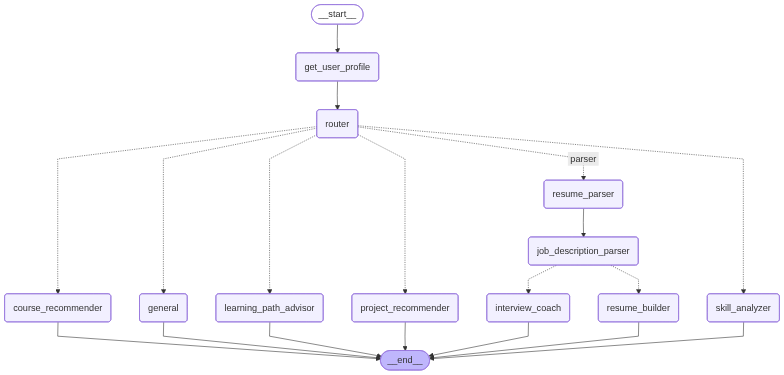

In [400]:
app

In [371]:
from langchain_core.prompts import ChatPromptTemplate

exit_prompt = ChatPromptTemplate.from_template(
    """
    You are a conversation manager.
    Given the user's latest message, decide if the user wants to end the conversation.
    
    If the user clearly says something like "bye", "thank you", "stop", "exit", "goodnight", etc., 
    respond ONLY with the single word: "exit".
    Otherwise, respond ONLY with the word: "continue"
    
    User message:
    {user_input}
    """)

exit_chain = exit_prompt | llm

memory = []
memory_summary = ""

while True:
    user_input = input("User: ")
    should_continue = exit_chain.invoke({'user_input' : user_input}).content
    
    if should_continue == "exit":
        print("AI: Goodbye 👋")
        break

    memory = memory[-10:]

    if memory:
        summary_prompt = ChatPromptTemplate.from_template(
            "Summarize the key context of this conversation in 5 concise sentences:\n\n{conversation}"
        )
        formatted = "\n".join(memory)
        chain = summary_prompt | llm
        memory_summary = chain.invoke({"conversation": formatted}).content.strip()
    else:
        memory_summary = ""

    state = {
        "input_text": user_input,
        "memory_summary": memory_summary,
    }

    result = app.invoke(state)
    response = result.get("response", "(No response)")

    print(f"AI: {response}\n")

    memory.append(f"User: {user_input}")
    memory.append(f"AI: {response}")


User:  what is my weakness


AI: Core Strengths:
- **Large Language Models (LLMs) & Generative AI:** Strong foundation in Agentic AI, RAG, LLMs, LangChain, and Transformers, backed by an IBM certification in RAG and Agentic AI.
- **Deep Learning:** Proficient in various deep learning architectures (LSTM, RNN, CNN) and frameworks (TensorFlow, PyTorch), demonstrated through projects like BiasBusterAI (Bidirectional LSTM) and SmartAttend (PyTorch, MTCNN, InceptionResNetV1). Certifications from DeepLearning.AI further solidify this.
- **Machine Learning Fundamentals:** Solid understanding of Supervised and Unsupervised Learning, along with practical skills in Scikit-learn, Numpy, Pandas, Matplotlib, and Seaborn.
- **Data Science & Analytics:** Comprehensive skills in Data Analytics, Data Science, Statistics, SQL, and Python, supported by certifications from Google and IBM.
- **Web Application Development for AI:** Proven ability to integrate AI models into web applications using Flask and Django, as showcased in both 

User:  ok thank you good bye


AI: Goodbye 👋


In [401]:
res = app.invoke({"input_text" : "who are you"})

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [392]:
res


{'input_text': 'who are you',
 'agent_action': 'skill_analyzer',
 'skills': ['Agentic AI',
  'Retrieval Augmented Generation (RAG)',
  'Large Language Models (LLMs)',
  'LangChain',
  'Django',
  'LSTM',
  'Flask',
  'Transformers',
  'RNN',
  'TensorFlow',
  'Supervised Learning',
  'Unsupervised Learning',
  'Pytorch',
  'CNN',
  'DBMS',
  'DSA',
  'Statistics',
  'SQL',
  'AI',
  'Linear Algebra',
  'Calculus',
  'PCA',
  'Python',
  'Seaborn',
  'Pandas',
  'Numpy',
  'Matplotlib',
  'Scikit-learn',
  'Data Analytics',
  'Data Science',
  'Machine Learning',
  'Jupyter Notebook',
  'Git'],
 'certifications': [{'name': 'Google Advanced Data Analytics',
   'organization': 'Google'},
  {'name': 'IBM Data Science Professional Certificate', 'organization': 'IBM'},
  {'name': 'IBM RAG and Agentic AI: Build Next-Gen AI Systems',
   'organization': 'IBM'},
  {'name': 'Deep Learning', 'organization': 'DeepLearningAI'},
  {'name': 'Machine Learning', 'organization': 'DeepLearningAI'},
  {'na